# Phosphorus Machine Learning Project

### See `utils.py` for the bones of the code.

### This notebook is exclusively for visualization.

In [1]:
import utils
from utils import *

from importlib import reload
# to reload utils, run:
utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in Data

In [3]:
ROOTDIR = Path()

CIDdir = ROOTDIR/"ProcessedData"
Listdir = ROOTDIR/"Categories"

X_data = get_Data(Listdir)

XANES_energies = X_data[0]['XANES_Spectra'][0]
XES_energies = X_data[0]['XES_Spectra'][0]

### Create dictionary maps for each CID based on different codes

In [4]:
X_data_classed = [c for c in X_data if c['Class']!='None']
compoundmap = {compound['CID']:compound for compound in X_data_classed}

CIDs = np.array([c['CID'] for c in X_data_classed])
NoneCIDs = np.array([c['CID'] for c in X_data if c['Class']=='None'])

# CLASSSIFICATION MAPS
# classes
classcodemap = {compound['CID']:CLASSCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in CLASSCODES.keys()}
classnames = list(CLASSCODES.keys())[:-1]

# coordination
coordcodemap = {compound['CID']:COORDCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in COORDCODES.keys()}
# phosphorane subclasses
phosphoranecodemap = {compound['CID']:PHOSPHORANECODES[compound['Class']] for compound in X_data_classed
                      if compound['Class'] in PHOSPHORANECODES.keys()}
# sulfur subclasses
sulfurcodemap = {compound['CID']:SULFURCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in SULFURCODES.keys()}

# OH subclasses
ohcodemap = {compound['CID']:OHCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in OHCODES.keys()}

# chargemap
chargemap = {compound['CID']:compound['Charge'] for compound in X_data_classed}

# t-SNE Analysis

## PCA + t-SNE

VtC-XES takes 6 PCs to explain 0.9094 variance
XANES takes 12 PCs to explain 0.9095 variance


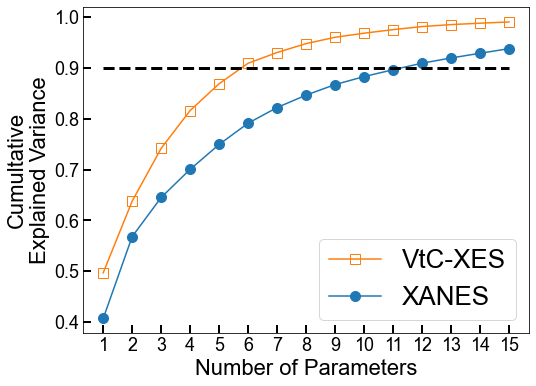

In [5]:
XES = np.array([c['XES_Normalized'] for c in X_data_classed])
XANES = np.array([c['XANES_Normalized'] for c in X_data_classed])

# pca
pca_all_xes = PCA()
XES_PCA = pca_all_xes.fit_transform(XES)
pca_all_xanes = PCA()
XANES_PCA = pca_all_xanes.fit_transform(XANES)

N = XANES_PCA.shape[1]

explained_var_xes = np.array([np.sum(pca_all_xes.explained_variance_ratio_[:i+1]) for i in range(N)])
explained_var_xanes = np.array([np.sum(pca_all_xanes.explained_variance_ratio_[:i+1]) for i in range(N)])

threshold_xes = np.where(explained_var_xes >= 0.9)[0][0]
threshold_xanes = np.where(explained_var_xanes >= 0.9)[0][0]

print(f"VtC-XES takes {threshold_xes+1} PCs to explain {explained_var_xes[threshold_xes]:.04f} variance")
print(f"XANES takes {threshold_xanes+1} PCs to explain {explained_var_xanes[threshold_xanes]:.04f} variance")

make_stacked_scree(pca_all_xes.explained_variance_ratio_, pca_all_xanes.explained_variance_ratio_, n=15)

# Coordination

* How does tricoordinate versus tetracoordinate compare?

In [49]:
X_coord, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XES')
X_coord, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XANES')

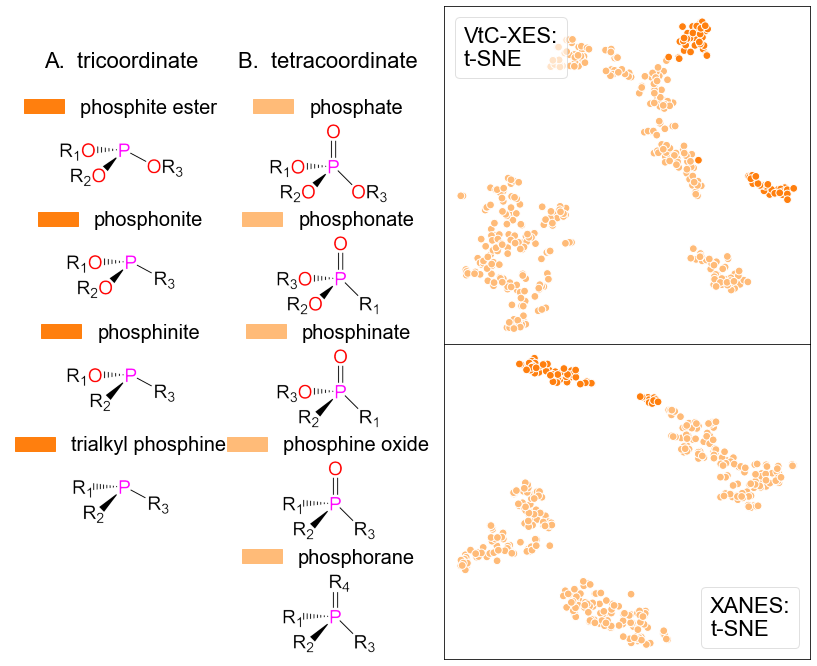

In [53]:
fig = plt.figure(figsize=(14,12))
asize = 0.25
spec = fig.add_gridspec(nrows=11, ncols=3,
                        width_ratios = [0.5, .5, 1.],
                        height_ratios=[1, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0.1, hspace=0)

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate\n', 'B.  tetracoordinate\n']

colorcode, codemap = COORDCODES, coordcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # make legend
        legax = fig.add_subplot(spec[2*i + 1,j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                              fontsize=20, framealpha=0, frameon=False)
        legax.axis('off')
        # show structure
        structax = fig.add_subplot(spec[2*i + 2,j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        structax.axis('off')
        
        if i == 0:
            legax.set_title(titles[j], fontsize=22)
            
ax = fig.add_subplot(spec[:6,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                              mode='XES', method='t-SNE', hiddencids=hiddenCIDS, fontsize=22,
                              size=60, edgecolors='w', **{'loc': 2})

ax = fig.add_subplot(spec[6:11,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                              mode='XANES', method='t-SNE', hiddencids=hiddenCIDS, fontsize=22,
                              size=60, edgecolors='w', **{'loc': 4})

plt.savefig(f'../Figures/coordination.png', dpi=800, transparent=False, bbox_inches='tight')

## Oxidation within coordination

* Within tricoordination and tetracoordinate compounds, how does the increase in oxidation state affect the location in the t-SNE reduced space?

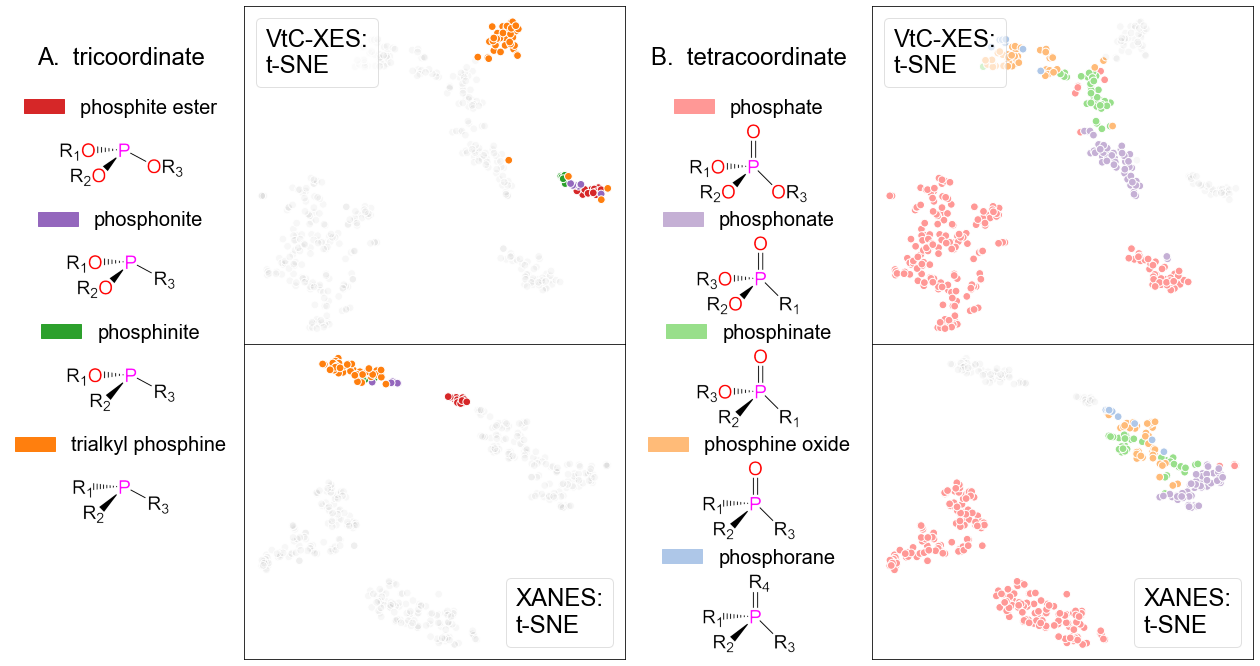

In [54]:
fig = plt.figure(figsize=(22,12))
asize = 0.25
spec = fig.add_gridspec(nrows=11, ncols=4,
                        width_ratios = [0.5, 1., 0.5, 1.],
                        height_ratios=[1, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0.1, hspace=0)

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate\n', 'B.  tetracoordinate\n']

colorcode, codemap = CLASSCODES, classcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # make legend
        legax = fig.add_subplot(spec[2*i + 1, 2*j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                              fontsize=20, framealpha=0, frameon=False)
        legax.axis('off')
        # show structure
        structax = fig.add_subplot(spec[2*i + 2, 2*j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        structax.axis('off')
        
        if i == 0:
            legax.set_title(titles[j], fontsize=24)

for i, coordnum in enumerate([3,4]):
    hiddencids = hiddenCIDS.copy()
    hiddencids += [cid for cid, coord in coordcodemap.items() if coord != coordnum]
    ax = fig.add_subplot(spec[:6, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                                  mode='XES', method='t-SNE', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.03, **{'loc': 2})

    ax = fig.add_subplot(spec[6:11, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                                  mode='XANES', method='t-SNE', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.03, **{'loc': 4})
    
    
plt.savefig(f'../Figures/oxidation.png', dpi=800, transparent=False, bbox_inches='tight')

# Spaghetti based on chemical classes (within coordination)

* How do tricoordinate versus tetracoordinate compare spectrally?

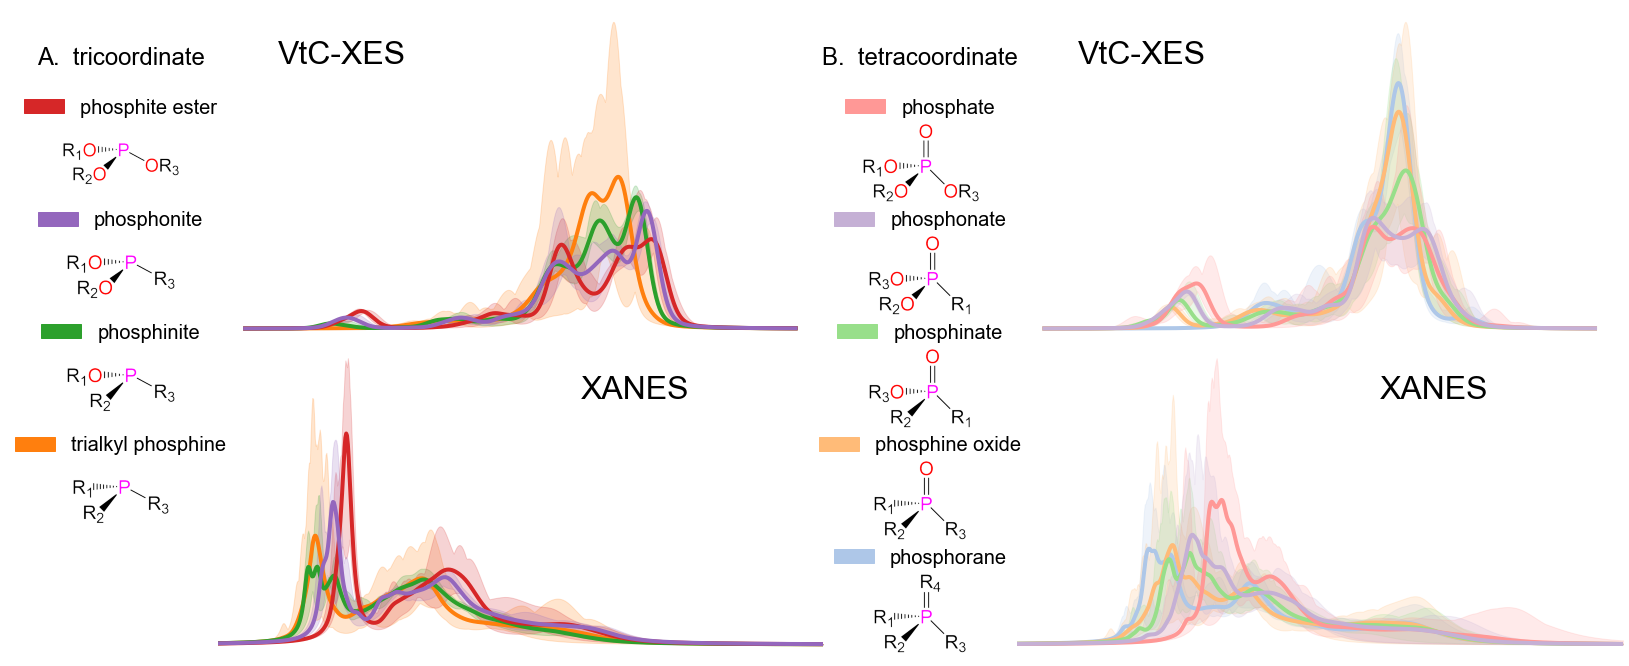

In [23]:
fig = plt.figure(figsize=(28,12))
asize = 0.25
spec = fig.add_gridspec(nrows=11, ncols=4,
                        width_ratios = [0.2, 1., 0.2, 1.],
                        height_ratios=[1, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0.1, hspace=0)

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate\n', 'B.  tetracoordinate\n']

colorcode, codemap = CLASSCODES, classcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # make legend
        legax = fig.add_subplot(spec[2*i + 1, 2*j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                              fontsize=20, framealpha=0, frameon=False)
        legax.axis('off')
        # show structure
        structax = fig.add_subplot(spec[2*i + 2, 2*j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        structax.axis('off')
        
        if i == 0:
            legax.set_title(titles[j], fontsize=24)

for i, coordnum in enumerate([3,4]):
    hiddencids = hiddenCIDS.copy()
    hiddencids += [cid for cid, coord in coordcodemap.items() if coord != coordnum]
    
    binmap = {cid:v-1 for cid, v in classcodemap.items() if cid not in hiddencids}
    ax = fig.add_subplot(spec[:6, 2*i + 1])
    
    spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XES',
                                   colorcodemap=binmap, binmap=binmap,
                                   fontsize=26, linewidth=4, scalecolor=False,
                                   hiddenalpha=0, coloralpha=1.0, average_bins=True,
                                   verbose=False)

    ax = fig.add_subplot(spec[6:11, 2*i + 1])
    
    spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XANES',
                                   colorcodemap=binmap, binmap=binmap,
                                   fontsize=26, linewidth=4, scalecolor=False,
                                   hiddenalpha=0, coloralpha=1.0, average_bins=True,
                                   verbose=False, energyrange=(2142,2175))
      
    
plt.savefig(f'../Figures/SI_oxidation_spaghetti.png', dpi=800, transparent=False, bbox_inches='tight')

## Phosphate subclusters

* Why are the phosphates being sub-divided into three different clusters?

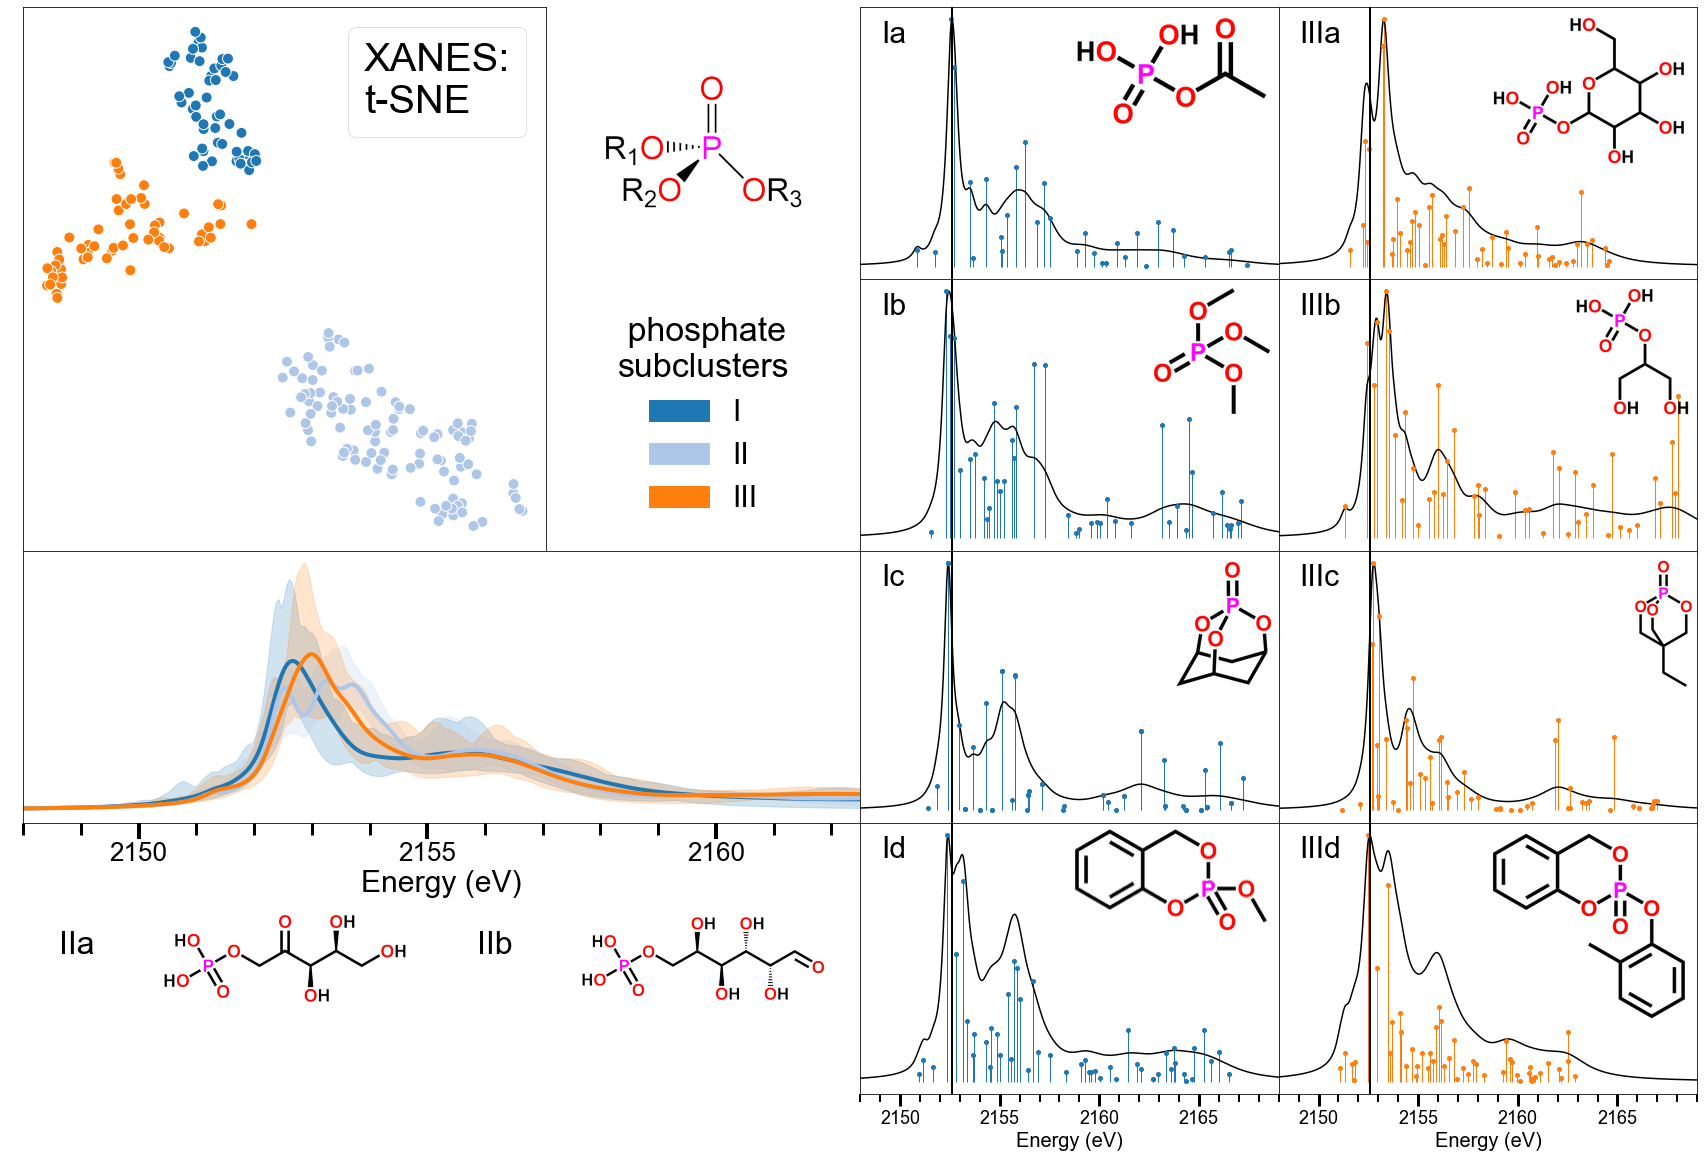

In [156]:
# kwargs options
options = {'loc':1, 'title': None}
kwargs = {'Class': ['phosphate']}

# examples
cluster_cids = np.array([[186, 10541, 120825, 119401],[466, 2526, 13869, 104993]])

# make figure
fig = plt.figure(figsize=(30,20))
spec = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1, 0.6, 0.8, 0.8])
plt.subplots_adjust(wspace=0, hspace=0)

############ create DBScan clusters
tsne_phosphates = np.array([XANES_tsnemap[c['CID']] for c in X_data_classed if c['Class'] == 'phosphate'])
cids_phosphates = [c['CID'] for c in X_data_classed if c['Class'] == 'phosphate']

dbscan_clustering = DBSCAN(eps=3.3, min_samples=1).fit(tsne_phosphates)
dbscan_clustermap = {cid:cluster for cid,cluster in zip(cids_phosphates, dbscan_clustering.labels_)}

############ plot all phosphates with clusters indicated by DBSCAN
phosphate_clustermap = {}
for c in X_data_classed:
    if c['Class'] == 'phosphate':
        phosphate_clustermap[c['CID']] = dbscan_clustermap[c['CID']] + 1
    else:
        phosphate_clustermap[c['CID']] = 0
              
select_clusters = [1,2,3]
X_phosphate = [c for c in X_data_classed if phosphate_clustermap[c['CID']] in select_clusters]

colorcodemap = {c['CID']:phosphate_clustermap[c['CID']] for c in X_data_classed \
          if phosphate_clustermap[c['CID']] in select_clusters}
binmap = {k:v - 1 for k,v in colorcodemap.items()}

# phosphate structure
structure = Image.open(f'../Figures/chemdraw/phosphate.png')
structure = resize_img(structure, ratio=(1,1.8))
structax = fig.add_subplot(spec[0, 1])
structax.imshow(structure)
structax.axis('off')

# make legend
legax = fig.add_subplot(spec[1, 1])
keys = {1:'I', 2:'II', 3:'III'}
patches = [mpatches.Patch(color=plt.cm.tab20(cluster - 1), label=keys[cluster])
           for cluster in select_clusters]
legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                     fontsize=30, framealpha=0, frameon=False,
                      title=' phosphate\nsubclusters', title_fontsize=34)
legax.axis('off')

############ zoomed in on clusters
ax = fig.add_subplot(spec[:2, 0])
tsne_plt = plot_dim_red((fig, ax), X_phosphate, XANES_tsnemap, size=120,
                        colorcodemap=phosphate_clustermap, hiddenalpha=0.03,
                        mode='XANES', method='t-SNE', fontsize=40,
                        edgecolors='w', **Merge(kwargs, options))

############ spaghetti plot of average clusters indicated by DBSCAN
ax = fig.add_subplot(spec[2, :2])
spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XANES',
                               colorcodemap=binmap, binmap=binmap, fontsize=26,
                               linewidth=4, energyrange=(2148,2162.5), scalecolor=False,
                               hiddenalpha=0, coloralpha=1.0, average_bins=True,
                               **Merge(kwargs, options))

ax.annotate('Averaged over cluster', (2155, 1), ha='left', va='top',
            size=28, xytext=(0, 0), textcoords='offset points')

##### example sticks
cluster_counts = [np.sum(dbscan_clustering.labels_ == cluster) for cluster in [0, 1, 2]]
show_clusters = np.delete([0, 1, 2], np.argmax(cluster_counts))

labels = [[f'{keys[show_clusters[0] + 1]}a', f'{keys[show_clusters[0] + 1]}b',\
           f'{keys[show_clusters[0] + 1]}c', f'{keys[show_clusters[0] + 1]}d'],\
          [f'{keys[show_clusters[1] + 1]}a', f'{keys[show_clusters[1] + 1]}b',\
           f'{keys[show_clusters[1] + 1]}c', f'{keys[show_clusters[1] + 1]}d']]

for j, cid_list in enumerate(cluster_cids):
    cluster = show_clusters[j]
    for i, cid in enumerate(cid_list):
        if i == 3:
            verbose = True
        else:
            verbose = False
        
        ax = fig.add_subplot(spec[i, j + 2])
        plot_spectrum_and_trans((fig, ax), compoundmap, cid, verbose=verbose,
                                mode='XANES', energyrange=(2148,2169), color=cluster,
                                link_pubchem=True, chemdraw=True, label=labels[j][i])
        
###### example structures
cids = [151020, 3034794]
labels = ['a', 'b']
for i, cid in enumerate(cids):
    ax = fig.add_subplot(spec[3, i])
    add_structure(fig, cids[i], ax, chemdraw=True, resize=True)
    ax.annotate(f'{keys[np.argmax(cluster_counts) + 1]}{labels[i]}',
                (0, 0), ha='right', va='top',
                size=32, xytext=(-0.2, 0.6), textcoords='axes fraction')
    
plt.savefig(f'../Figures/phosphate_subclusters.png', dpi=800, transparent=False, bbox_inches='tight')

In [56]:
# ### SI figures
# for select in [0,1,2]:
#     cids = []
#     for cid, cluster in dbscan_clustermap.items():
#         if cluster == select and compoundmap[cid]['Charge'] != -1 and cid not in cluster_cids:
#             cids += [cid]

#     N = 5
#     cids = np.array(cids[:N*2]).reshape((2,N))
#     print(cids)
    
#     fig, axes = plt.subplots(nrows=N, ncols=2, figsize=(15,N*5))
#     plt.subplots_adjust(wspace=0, hspace=0)

#     for cluster, cid_list in enumerate(cids):
#         for i, cid in enumerate(cid_list):
#             if i == N-1:
#                 verbose = True
#             else:
#                 verbose = False
#             plot_spectrum_and_trans((fig, axes[i, cluster]), compoundmap, cid, verbose=verbose,
#                                     mode='XANES', energyrange=(2148,2169), color=select,
#                                     link_pubchem=True)
#     plt.savefig(f'../Figures/SI_phosphate_cluster_{select + 1}.png', dpi=800, bbox_inches='tight')

In [11]:
# 186 vs 466 (both have OH H-bonded intramolecularly but 466 has additional H bond with OR group)
# same with 186 vs 11988266
# vs 107737 (2 OH with only OR H-bonded)
# 10541 vs 13134 (3 H bonds for all 3 Os vs just 2 Os)
# same with 6535 vs 654
# 120825 vs 13869 (1 H bond each vs 2 H-bonds each)
# 11207678 vs 104993 (2 OR H bonding vs 1)

## Sulfur-included bonding environment

* How does changing the ligand from carbon to sulfur impact the t-SNE clustering?

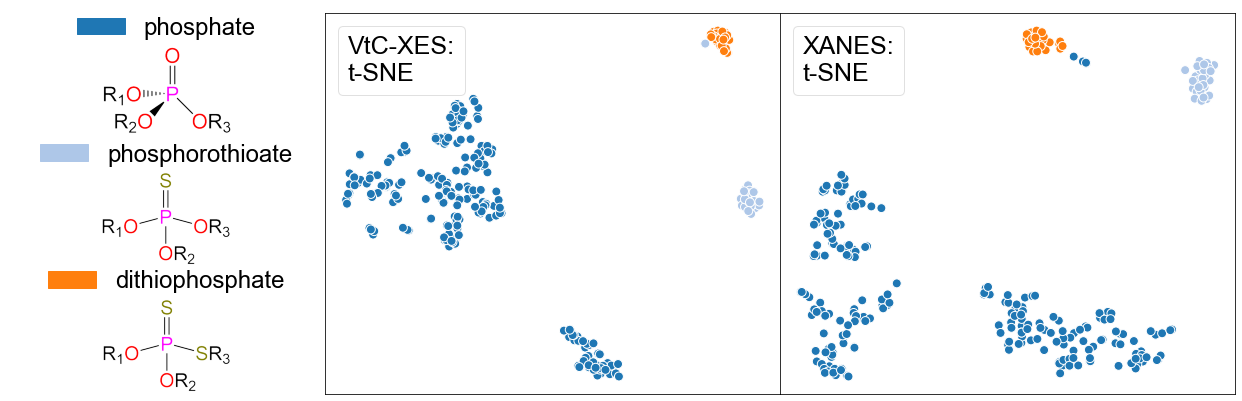

In [81]:
# sulfur subclasses
codemap = sulfurcodemap
labels = ['phosphate', 'phosphorothioate', 'dithiophosphate']
bin_names = list(SULFURCODES.keys())
N = len(labels)

fig = plt.figure(figsize=(22,7))
spec = fig.add_gridspec(nrows=N*2, ncols=3, width_ratios=[0.7, 1, 1],
                        height_ratios=[0.3, 1, 0.3, 1, 0.3, 1])
plt.subplots_adjust(wspace=0, hspace=0)

kwargs = {'Class': labels}
options = {'loc':2}

X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES', perplexity=20,
                                                              **kwargs)
X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES', perplexity=18,
                                                                  **kwargs)

structures = [plt.imread(f'../Figures/chemdraw/{clsname}.png') for clsname in labels]

for i, structure in enumerate(structures):
    # make legend
    legax = fig.add_subplot(spec[2*i,0])
    patches = [mpatches.Patch(color=plt.cm.tab20(i), label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                          fontsize=24, framealpha=0, frameon=False)
    legax.axis('off')
    # show structure
    structax = fig.add_subplot(spec[2*i+1,0])
    structax.imshow(structures[i])
    structax.axis('off')

for mode in ['XES', 'XANES']:
    if mode == 'XES':
        tsnemap = XES_tsnemap
        col = 1
    else:
        tsnemap = XANES_tsnemap
        col = 2
    #################### tsne plot
    ax = fig.add_subplot(spec[:N*2,col])
    tsne_plt = plot_dim_red((fig, ax), X_subset, tsnemap, size=80,
                            colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                            mode=mode, method='t-SNE', fontsize=25, edgecolors='w',
                            **Merge(kwargs, options))
    add_point_pubchem_link(tsne_plt, X_subset)
    
plt.savefig(f'../Figures/sulfur.png', dpi=800, transparent=False, bbox_inches='tight')

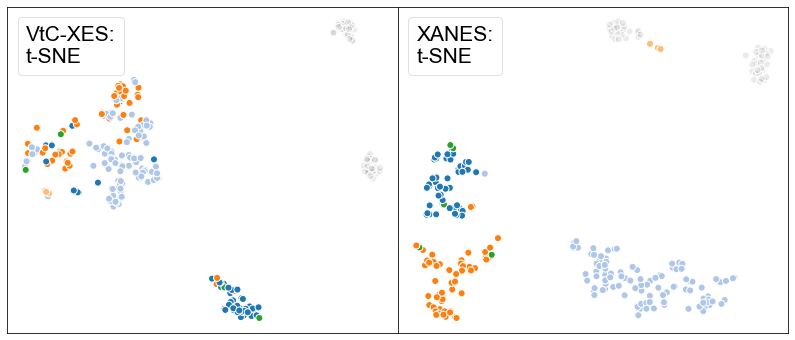

In [83]:
fig = plt.figure(figsize=(14,6))
spec = fig.add_gridspec(nrows=1, ncols=2)
plt.subplots_adjust(wspace=0, hspace=0)

kwargs = {'Class': labels}
options = {'loc':2}

for mode in ['XES', 'XANES']:
    if mode == 'XES':
        tsnemap = XES_tsnemap
        col = 0
    else:
        tsnemap = XANES_tsnemap
        col = 1
    #################### tsne plot
    ax = fig.add_subplot(spec[:N*2,col])
    
    hiddenCIDS += [cid for cid, cluster in phosphate_clustermap.items() if cluster == 0]
    tsne_plt = plot_dim_red((fig, ax), X_subset, tsnemap, size=50, hiddencids=hiddenCIDS,
                            colorcodemap=phosphate_clustermap, coloralpha=1., hiddenalpha=0.08,
                            mode=mode, method='t-SNE', fontsize=21, edgecolors='w',
                            **Merge(kwargs, options))
    add_point_pubchem_link(tsne_plt, X_subset)
    
plt.savefig(f'../Figures/sulfur_color_by_phosphates.png', dpi=800, transparent=False, bbox_inches='tight')

# OH group dependence

* How do hydroxyls, i.e., an H instead of a C, impact the spectra?

* Does UMAP perform as well as t-SNE?

In [38]:
%matplotlib inline

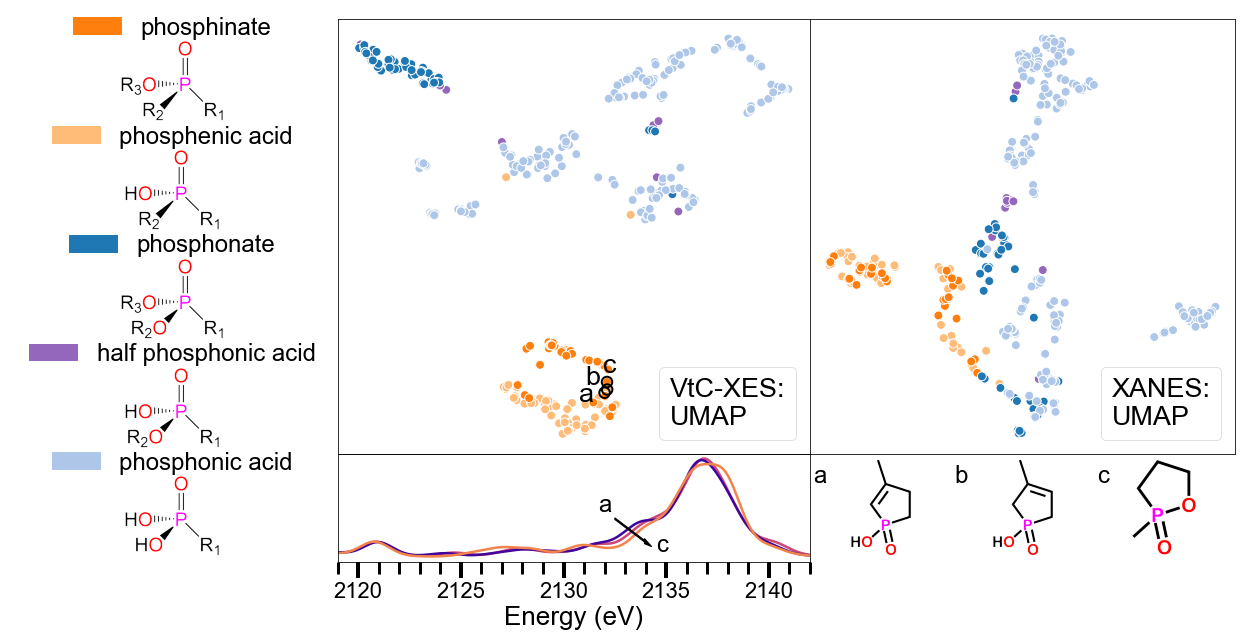

In [41]:
labels = ['phosphinate', 'phosphenic_acid', 'phosphonate', 'half_phosphonic_acid', 'phosphonic_acid']
structures = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in labels]
colorcode, codemap = OHCODES, ohcodemap
N = len(labels)

for method in ['UMAP']:

    ########## set up figure with axes
    fig = plt.figure(figsize=(22,10))
    ratio = 0.2
    spec = fig.add_gridspec(nrows=N*2, ncols=5, width_ratios=[0.7, 1, 0.3, 0.3, 0.3],
                            height_ratios=[ratio, 1, ratio, 1, ratio, 1, ratio, 1, ratio, 1])
    plt.subplots_adjust(wspace=0, hspace=0)

    ########## set up formatting kwargs and variables
    if method == 't-SNE':
        loc = 1
    elif method == 'UMAP':
        loc = 4
    kwargs = {'Class': labels, 'loc':loc, 'title': ''}

    ########## get reuced spaces with corresponding maps
#     X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES',
#                                                                   method=method, **kwargs)
#     X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES',
#                                                                       method=method, **kwargs)
    cid_subset = [c['CID'] for c in X_data_classed if c['Class'] in labels]

    ########## make first column with structures
    for i, structure in enumerate(structures):
        
        # make legend
        legax = fig.add_subplot(spec[2*i,0])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[i]] - 1),
                                  label=(labels[i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                              fontsize=24, framealpha=0, frameon=False)
        legax.axis('off')
        
        # show structure
        structax = fig.add_subplot(spec[2*i+1,0])
        structax.imshow(structures[i])
        structax.axis('off')

    if method == 't-SNE':
        select_cids = [312437, 88779457, 10397098]
        label = ['a', 'b', 'c']
        colorcodemap = {312437:0.1, 88779457:0.5, 10397098:0.7}
        offsets = [(-20, -20), (-12, 0), (10, 15)]
    
    elif method == 'UMAP':
        select_cids = [98611, 21720419, 104467]
        label = ['a', 'b', 'c']
        colorcodemap = {98611:0.1, 21720419:0.5, 104467:0.7} 
        offsets = [(-18, -14), (-14, 0), (3, 5)]

    for mode in ['XES', 'XANES']:

        if mode == 'XES':
            energyrange = (2119, 2142)
            tsnemap = XES_tsnemap   

            ###### spaghetti plot of selected cids
            ax = fig.add_subplot(spec[N*2-2:, 1])

            spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode=mode, scalecolor=False,
                                           colorcodemap=colorcodemap, colormap=plt.cm.plasma,
                                           linewidth=2.5, hiddenalpha=0, coloralpha=1.0,
                                           energyrange=energyrange, **Merge(kwargs, options))

            ###### drawing arrow and annotating
            x, y, dx, dy = 2132.5, 1.18, 1.8, -0.13
            arr = mpl.patches.Arrow(x, y, dx, dy, width=0.04, linestyle='-',
                                    edgecolor='k', facecolor='k', zorder=5)
            ax.add_patch(arr)
            ax.annotate('a', (x, y), ha='center', va='bottom',
                        size=24, xytext=(-10, 2), textcoords='offset points')
            ax.annotate('c', (x + dx, y + dy), ha='center', va='bottom',
                        size=24, xytext=(10, -10), textcoords='offset points')

            #### select options for the 2D plot
            options = Merge(kwargs, {'CID': select_cids, 'offsets':offsets, 'label':label})
            subax = fig.add_subplot(spec[:N*2-2, 1])

        elif mode == 'XANES':
            
            ##### show selected cid structures
            for i, cid in enumerate(select_cids):
                structax = fig.add_subplot(spec[-2:, 2 + i])
                add_structure(fig, cid, structax, chemdraw=True)
                structax.annotate(label[i], (0, 0), ha='right', va='top',
                            size=24, xytext=(0, 0.9), textcoords='axes fraction')
            
            ##### specifying mapping and subplot
            tsnemap = XANES_tsnemap
            options = kwargs
            subax = fig.add_subplot(spec[:N*2-2, 2:])

        #################### tsne plot   
        tsne_plt = plot_dim_red((fig, subax), X_subset, tsnemap, size=80, 
                                colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                                mode=mode, method=method, fontsize=27, edgecolors='w',
                                large_ticks=False, **options)
        
        add_point_label(tsne_plt, X_subset)
        
    plt.savefig(f'../Figures/{method}_OH.png', dpi=800, transparent=False, bbox_inches='tight')

In [4]:
cid = 312437
C1 = np.array([-0.52751, -0.67727, -1.63603])
C2 = np.array([1.72359, -0.45014, -0.21939])

cosine_angle = np.dot(C1, C2) / (np.linalg.norm(C1) * np.linalg.norm(C2))
angle = np.arccos(cosine_angle)

print(f'{cid}: {np.degrees(angle)} deg')

312437: 94.2441315483583 deg


In [5]:
cid = 88779457
C1 = np.array([-0.78480, 1.66303, -0.20829])
C2 = np.array([1.57470 , 0.36444, -0.87968])         

cosine_angle = np.dot(C1, C2) / (np.linalg.norm(C1) * np.linalg.norm(C2))
angle = np.arccos(cosine_angle)

print(f'{cid}: {np.degrees(angle)} deg')

88779457: 97.5339755154193 deg


In [6]:
cid = 10397098

C1 = np.array([-1.70869, 0.69843, -0.07240])
C2 = np.array([1.13638, 1.29924, 0.56355])

cosine_angle = np.dot(C1, C2) / (np.linalg.norm(C1) * np.linalg.norm(C2))
angle = np.arccos(cosine_angle)

print(f'{cid}: {np.degrees(angle)} deg')

10397098: 108.69377760905921 deg
